# Gridding agricultural census data - MERA

Gridding based on
<https://james-brennan.github.io/posts/fast_gridding_geopandas/>

In [1]:
# import libraries
import os
import itertools
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import xarray as xr
import climag.plot_configs as cplt

## Open some gridded climate data

In [2]:
TS_FILE = os.path.join("data", "MERA", "IE_MERA_FC3hr_3_day.nc")

In [3]:
data = xr.open_dataset(TS_FILE, chunks="auto", decode_coords="all")

In [4]:
data

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9497)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 ...
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1980-01-01 ... 2005-12-31
    spatial_ref        int64 ...
Data variables:
    PAR                (time, y, x) float32 dask.array<chunksize=(4932, 85, 80), meta=np.ndarray>
    PET                (time, y, x) float32 dask.array<chunksize=(4932, 85, 80), meta=np.ndarray>
    T                  (time, y, x) float32 dask.array<chunksize=(4932, 85, 80), meta=np.ndarray>
    PP                 (time, y, x) float32 dask.array<chunksize=(4932, 85, 80), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    dataset:      IE_MERA_FC3hr_3_day

In [5]:
# keep only one var
data = data.drop_vars(["PAR", "PET", "PP"])

## Use the gridded data's bounds to generate a gridded vector layer

In [6]:
data.rio.bounds()

(413750.0, 406250.0, 808750.0, 821250.0)

In [8]:
xmin, ymin, xmax, ymax = data.rio.bounds()
# the difference between two adjacent rotated lat or lon values is the
# cell size
cell_size = float(data["y"][1] - data["y"][0])

In [9]:
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
grid_cells = gpd.GeoDataFrame(
    grid_cells, columns=["geometry"], crs=cplt.lambert_conformal
)

In [10]:
grid_cells.shape

(26553, 1)

In [11]:
grid_cells.head()

,geometry
0,"POLYGON ((411250.000 406250.000, 411250.000 40..."
1,"POLYGON ((411250.000 408750.000, 411250.000 41..."
2,"POLYGON ((411250.000 411250.000, 411250.000 41..."
3,"POLYGON ((411250.000 413750.000, 411250.000 41..."
4,"POLYGON ((411250.000 416250.000, 411250.000 41..."


In [12]:
grid_cells.crs

<Derived Projected CRS: +proj=lcc +ellps=WGS84 +lon_0=5.0 +lat_0=53.5 +x_0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (1SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Subset climate data to visualise the cells

In [13]:
data_ = data.isel(time=0)

In [14]:
data_

<xarray.Dataset>
Dimensions:            (x: 158, y: 166)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 ...
    Lambert_Conformal  int64 ...
    time               datetime64[ns] 1980-01-01
    spatial_ref        int64 ...
Data variables:
    T                  (y, x) float32 dask.array<chunksize=(85, 80), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    dataset:      IE_MERA_FC3hr_3_day

In [16]:
# find number of grid cells with data
len(data_["T"].values.flatten()[np.isfinite(data_["T"].values.flatten())])

14490

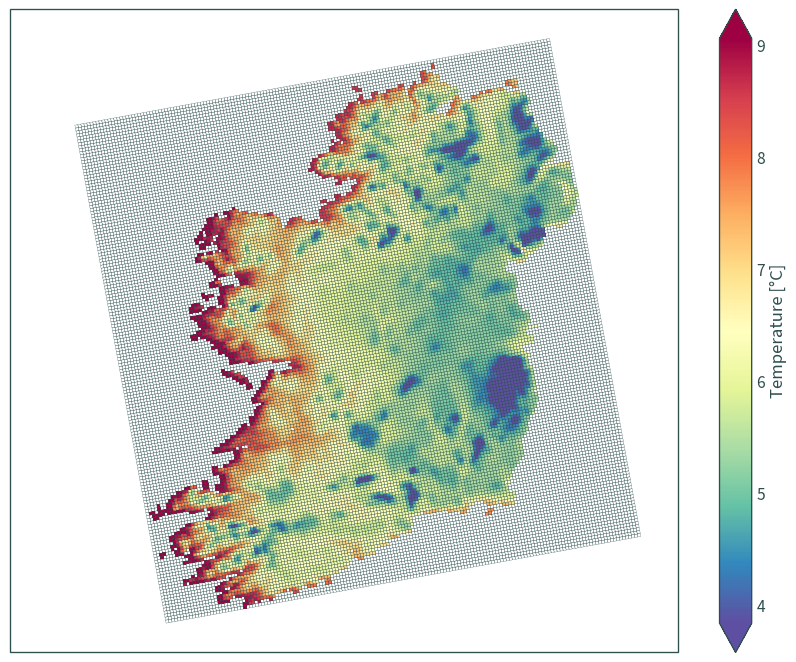

In [17]:
plt.figure(figsize=(9, 7))
axs = plt.axes(projection=cplt.plot_projection)

# plot data for the variable
data_["T"].plot(
    ax=axs,
    cmap="Spectral_r",
    x="x",
    y="y",
    robust=True,
    transform=cplt.lambert_conformal
)
grid_cells.to_crs(cplt.plot_projection).boundary.plot(
    ax=axs, color="darkslategrey", linewidth=.2
)

axs.set_title(None)
plt.axis("equal")
plt.tight_layout()
plt.show()

## Drop grid cells without climate data

In [ ]:
grid_centroids = {
    "wkt": [],
    "x": [],
    "y": []
}

for x, y in itertools.product(
    range(len(data.coords["x"])), range(len(data.coords["y"]))
):
    data__ = data.isel(x=x, y=y)

    # ignore null cells
    if not data__["T"].isnull().all():
        grid_centroids["wkt"].append(
            f"POINT ({float(data__['x'].values)} "
            f"{float(data__['y'].values)})"
        )
        grid_centroids["x"].append(float(data__["x"].values))
        grid_centroids["y"].append(float(data__["y"].values))

In [ ]:
grid_centroids = gpd.GeoDataFrame(
    grid_centroids,
    geometry=gpd.GeoSeries.from_wkt(
        grid_centroids["wkt"], crs=cplt.lambert_conformal
    )
)

In [ ]:
grid_centroids.head()

,wkt,x,y,geometry
0,POINT (415000.0 497500.0),415000.0,497500.0,POINT (415000.000 497500.000)
1,POINT (417500.0 460000.0),417500.0,460000.0,POINT (417500.000 460000.000)
2,POINT (417500.0 462500.0),417500.0,462500.0,POINT (417500.000 462500.000)
3,POINT (417500.0 492500.0),417500.0,492500.0,POINT (417500.000 492500.000)
4,POINT (417500.0 495000.0),417500.0,495000.0,POINT (417500.000 495000.000)


In [ ]:
grid_centroids.shape

(14490, 4)

In [ ]:
grid_centroids.crs

<Derived Projected CRS: +proj=lcc +ellps=WGS84 +lon_0=5.0 +lat_0=53.5 +x_0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (1SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
grid_cells = gpd.sjoin(
    grid_cells, grid_centroids.to_crs(cplt.lambert_conformal)
)

In [ ]:
grid_cells.drop(columns=["wkt", "index_right"], inplace=True)

In [ ]:
grid_cells.head()

,geometry,x,y
203,"POLYGON ((413750.000 496250.000, 413750.000 49...",415000.0,497500.0
355,"POLYGON ((416250.000 458750.000, 416250.000 46...",417500.0,460000.0
356,"POLYGON ((416250.000 461250.000, 416250.000 46...",417500.0,462500.0
368,"POLYGON ((416250.000 491250.000, 416250.000 49...",417500.0,492500.0
369,"POLYGON ((416250.000 493750.000, 416250.000 49...",417500.0,495000.0


In [ ]:
grid_cells.shape

(14490, 3)

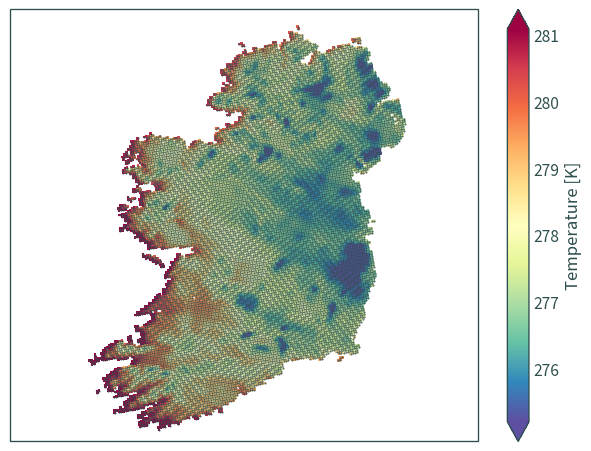

In [28]:
# plt.figure(figsize=(9, 7))
axs = plt.axes(projection=cplt.plot_projection)

# plot data for the variable
data_["T"].plot(
    ax=axs,
    cmap="Spectral_r",
    x="x",
    y="y",
    robust=True,
    transform=cplt.lambert_conformal
)

grid_cells.to_crs(cplt.plot_projection).plot(
    ax=axs, edgecolor="darkslategrey", facecolor="none", linewidth=.05
)

grid_centroids.to_crs(cplt.plot_projection).plot(
    ax=axs, color="darkslategrey", markersize=.2
)

axs.set_title(None)
plt.axis("equal")
plt.tight_layout()
plt.show()

## Read stocking rate data

In [29]:
stocking_rate = gpd.read_file(
    os.path.join("data", "agricultural_census", "agricultural_census.gpkg"),
    layer="stocking_rate"
)

In [30]:
stocking_rate.crs

<Derived Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [31]:
stocking_rate.head()

,ENGLISH,COUNTY,PROVINCE,GUID,total_cattle,total_sheep,total_grass_hectares,electoral_division,WD22CD,WD22NM,ward_2014_name,stocking_rate,geometry
0,TURNAPIN,DUBLIN,Leinster,2ae19629-1cea-13a3-e055-000000000001,0.0,0.0,0.0,"Turnapin, Co.Dublin, 04042",0,0,0,0.000000,"POLYGON ((717716.712 741601.510, 717759.461 74..."
1,DRUMLUMMAN,CAVAN,Ulster,2ae19629-1caa-13a3-e055-000000000001,2673.0,231.0,1249.1,"Drumlumman, Co.Cavan, 32089",0,0,0,1.730446,"POLYGON ((637756.185 787640.988, 637753.646 78..."
2,CASTLEFORE,LEITRIM,Connacht,2ae19629-171c-13a3-e055-000000000001,630.0,0.0,805.9,"Castlefore, Co.Leitrim, 28063",0,0,0,0.625388,"POLYGON ((608196.069 807618.950, 608244.536 80..."
3,RAHONA,CLARE,Munster,2ae19629-1fec-13a3-e055-000000000001,2369.0,0.0,1349.9,"Rahona, Co.Clare, 16101",0,0,0,1.403956,"POLYGON ((484212.068 651795.629, 484231.866 65..."
4,CROSSAKEEL,MEATH,Leinster,2ae19629-1861-13a3-e055-000000000001,4826.0,671.0,2014.1,"Crossakeel, Co.Meath, 11061",0,0,0,1.950201,"POLYGON ((663308.409 776111.796, 663305.294 77..."


In [32]:
stocking_rate.shape

(3917, 13)

In [33]:
stocking_rate["stocking_rate"].max()

5.627624825011666

In [34]:
stocking_rate["stocking_rate"].min()

0.0

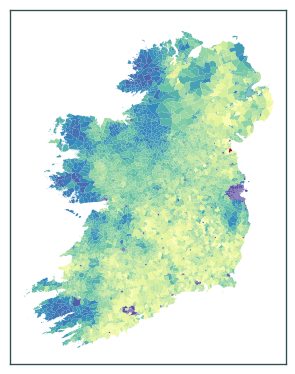

In [35]:
stocking_rate.plot(column="stocking_rate", cmap="Spectral_r")
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

## Reproject cells to the CRS of the stocking rate data

In [36]:
# use a projected CRS (e.g. 2157) instead of a geographical CRS (e.g. 4326)
grid_cells = grid_cells.to_crs(stocking_rate.crs)

In [37]:
grid_cells.head()

,geometry,x,y
203,"POLYGON ((415227.037 594343.036, 414771.907 59...",415000.0,497500.0
355,"POLYGON ((424513.435 557931.478, 424058.108 56...",417500.0,460000.0
356,"POLYGON ((424058.108 560389.011, 423602.795 56...",417500.0,462500.0
368,"POLYGON ((418595.321 589882.162, 418140.190 59...",417500.0,492500.0
369,"POLYGON ((418140.190 592340.144, 417685.076 59...",417500.0,495000.0


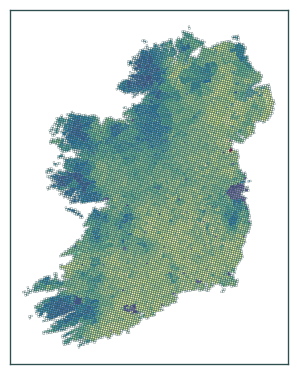

In [38]:
axs = stocking_rate.plot(column="stocking_rate", cmap="Spectral_r")
grid_cells.boundary.plot(color="darkslategrey", linewidth=.2, ax=axs)
axs.tick_params(labelbottom=False, labelleft=False)
plt.show()

## Create gridded stocking rate data

In [39]:
merged = gpd.sjoin(stocking_rate, grid_cells, how="left")

In [40]:
merged.head()

,ENGLISH,COUNTY,PROVINCE,GUID,total_cattle,total_sheep,total_grass_hectares,electoral_division,WD22CD,WD22NM,ward_2014_name,stocking_rate,geometry,index_right,x,y
0,TURNAPIN,DUBLIN,Leinster,2ae19629-1cea-13a3-e055-000000000001,0.0,0.0,0.0,"Turnapin, Co.Dublin, 04042",0,0,0,0.000000,"POLYGON ((717716.712 741601.510, 717759.461 74...",21781,737500.0,585000.0
0,TURNAPIN,DUBLIN,Leinster,2ae19629-1cea-13a3-e055-000000000001,0.0,0.0,0.0,"Turnapin, Co.Dublin, 04042",0,0,0,0.000000,"POLYGON ((717716.712 741601.510, 717759.461 74...",21782,737500.0,587500.0
1,DRUMLUMMAN,CAVAN,Ulster,2ae19629-1caa-13a3-e055-000000000001,2673.0,231.0,1249.1,"Drumlumman, Co.Cavan, 32089",0,0,0,1.730446,"POLYGON ((637756.185 787640.988, 637753.646 78...",17129,667500.0,645000.0
1,DRUMLUMMAN,CAVAN,Ulster,2ae19629-1caa-13a3-e055-000000000001,2673.0,231.0,1249.1,"Drumlumman, Co.Cavan, 32089",0,0,0,1.730446,"POLYGON ((637756.185 787640.988, 637753.646 78...",17296,670000.0,645000.0
1,DRUMLUMMAN,CAVAN,Ulster,2ae19629-1caa-13a3-e055-000000000001,2673.0,231.0,1249.1,"Drumlumman, Co.Cavan, 32089",0,0,0,1.730446,"POLYGON ((637756.185 787640.988, 637753.646 78...",17130,667500.0,647500.0


In [41]:
merged.shape

(37997, 16)

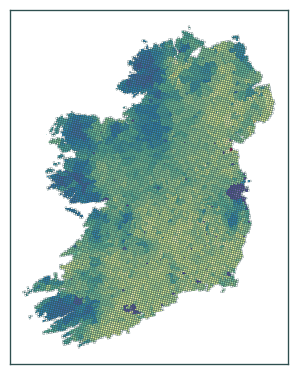

In [42]:
axs = merged.plot(column="stocking_rate", cmap="Spectral_r")
grid_cells.boundary.plot(color="darkslategrey", linewidth=.2, ax=axs)
axs.tick_params(labelbottom=False, labelleft=False)
plt.show()

In [43]:
# compute stats per grid cell, use the mean stocking rate
dissolve = merged[["stocking_rate", "index_right", "geometry"]].dissolve(
    by="index_right", aggfunc=np.mean
)

In [44]:
dissolve.shape

(14485, 2)

In [45]:
dissolve.head()

,geometry,stocking_rate
index_right,,
203,"MULTIPOLYGON (((421214.433 590565.624, 421215....",0.917024
355,"MULTIPOLYGON (((424582.660 560554.883, 424573....",0.763591
356,"MULTIPOLYGON (((424582.660 560554.883, 424573....",0.763591
368,"MULTIPOLYGON (((421214.433 590565.624, 421215....",0.917024
369,"MULTIPOLYGON (((421214.433 590565.624, 421215....",0.917024


In [46]:
len(dissolve.index.unique())

14485

In [47]:
# merge with cell data
grid_cells.loc[dissolve.index, "sr"] = dissolve["stocking_rate"].values

In [48]:
grid_cells.head()

,geometry,x,y,sr
203,"POLYGON ((415227.037 594343.036, 414771.907 59...",415000.0,497500.0,0.917024
355,"POLYGON ((424513.435 557931.478, 424058.108 56...",417500.0,460000.0,0.763591
356,"POLYGON ((424058.108 560389.011, 423602.795 56...",417500.0,462500.0,0.763591
368,"POLYGON ((418595.321 589882.162, 418140.190 59...",417500.0,492500.0,0.917024
369,"POLYGON ((418140.190 592340.144, 417685.076 59...",417500.0,495000.0,0.917024


In [49]:
grid_cells.shape

(14490, 4)

In [50]:
len(grid_cells["geometry"].unique())

14490

In [51]:
grid_cells["sr"].max()

4.190846310810918

In [52]:
grid_cells["sr"].min()

0.0

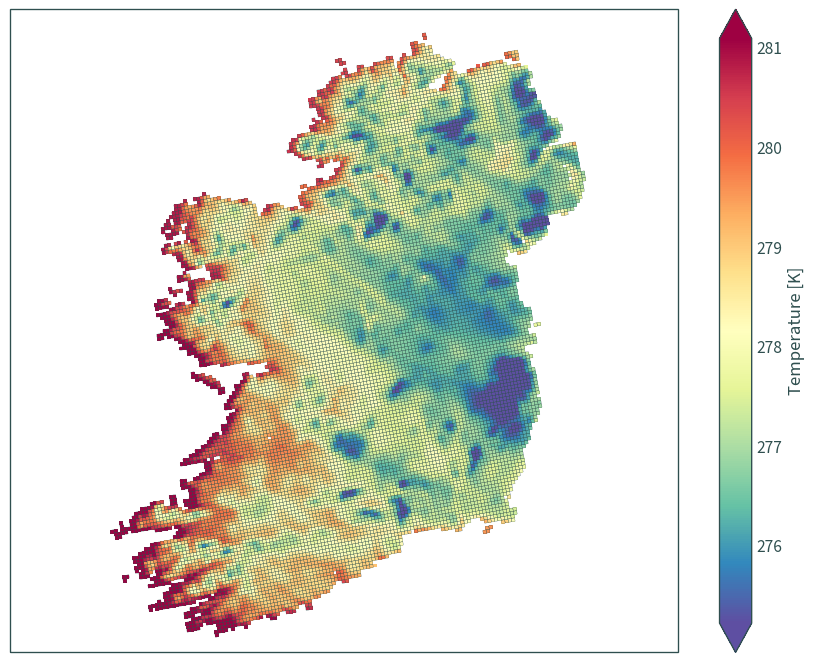

In [53]:
plt.figure(figsize=(9, 7))
axs = plt.axes(projection=cplt.plot_projection)

# plot data for the variable
data_["t"].plot(
    ax=axs,
    cmap="Spectral_r",
    x="x",
    y="y",
    robust=True,
    transform=cplt.lambert_conformal
)

grid_cells.to_crs(cplt.plot_projection).plot(
    column="sr", ax=axs, edgecolor="darkslategrey",
    facecolor="none", linewidth=.2
)

axs.set_title(None)
plt.axis("equal")
plt.tight_layout()
plt.show()

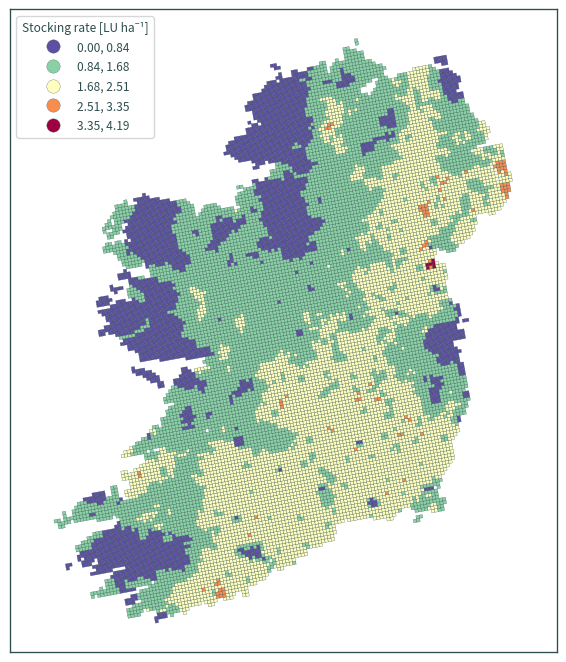

In [54]:
axs = grid_cells.plot(
    column="sr", cmap="Spectral_r", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}",
        "title": "Stocking rate [LU ha⁻¹]"
    }
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [56]:
grid_cells.to_file(
    os.path.join("data", "ModVege", "params.gpkg"), layer="mera"
)